## PROJECT:Overtime Abuse Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [7]:
df = pd.read_csv("payroll_sample_1500_rows.csv")

df.head()

,payroll_id,employee_id,pay_period_start,pay_period_end,pay_date,payroll_type,base_salary,hourly_rate,hours_worked,overtime_hours,...,status,created_at,created_by,updated_at,updated_by,is_active,notes,tax_regime,effective_from,effective_to
0,1,1,2023-01-01,2023-01-30,2023-01-31,Monthly,9144.53,NaN,NaN,11.84,...,Processed,2026-01-01 16:38:39,9,2026-01-01 20:38:39,32,True,NaN,Old Regime,NaN,NaN
1,2,2,2023-01-01,2023-01-28,2023-02-02,Monthly,9715.09,NaN,NaN,4.95,...,Processed,2025-11-05 16:38:39,1,2025-11-05 22:38:39,49,True,Adjustment for overtime,Old Regime,2023-01-11,2023-09-20
2,3,3,2023-01-01,2023-01-29,2023-01-31,Monthly,7313.67,NaN,NaN,0.05,...,Processed,2025-12-30 16:38:39,43,2025-12-30 19:38:39,45,True,Adjustment for overtime,Old Regime,2024-07-29,2025-06-12
3,4,4,2023-01-01,2023-01-28,2023-01-31,Monthly,11930.72,NaN,NaN,7.66,...,Processed,2026-01-18 16:38:39,48,2026-01-18 17:38:39,47,False,Tax revision,Old Regime,2023-05-14,2023-09-26
4,5,5,2023-01-01,2023-02-01,2023-02-05,Monthly,10811.00,NaN,NaN,16.11,...,Paid,2026-01-12 16:38:39,32,2026-01-12 21:38:39,23,True,Adjustment for overtime,NaN,NaN,NaN


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payroll_id                1500 non-null   int64  
 1   employee_id               1500 non-null   int64  
 2   pay_period_start          1500 non-null   object 
 3   pay_period_end            1500 non-null   object 
 4   pay_date                  1500 non-null   object 
 5   payroll_type              1500 non-null   object 
 6   base_salary               1170 non-null   float64
 7   hourly_rate               330 non-null    float64
 8   hours_worked              330 non-null    float64
 9   overtime_hours            1500 non-null   float64
 10  overtime_rate_multiplier  1500 non-null   float64
 11  gross_earnings            1500 non-null   float64
 12  bonus_amount              1500 non-null   float64
 13  commission_amount         1500 non-null   float64
 14  allowanc

In [9]:
# Fill missing values logically
df['hours_worked'] = df['hours_worked'].fillna(160)
df['hourly_rate'] = df['hourly_rate'].fillna(df['base_salary'] / 160)

# Replace infinities if any
df.replace([np.inf, -np.inf], 0, inplace=True)


In [10]:
# Overtime as proportion of work
df['overtime_ratio'] = df['overtime_hours'] / df['hours_worked']

# Overtime pay calculation
df['overtime_pay'] = (
    df['overtime_hours'] *
    df['overtime_rate_multiplier'] *
    df['hourly_rate']
)

# Contribution of overtime to total earnings
df['overtime_pay_ratio'] = df['overtime_pay'] / df['gross_earnings']

df[['overtime_hours','overtime_ratio','overtime_pay_ratio']].head()


,overtime_hours,overtime_ratio,overtime_pay_ratio
0,11.84,0.074000,0.100576
1,4.95,0.030937,0.029618
2,0.05,0.000313,0.000513
3,7.66,0.047875,0.046786
4,16.11,0.100687,0.085573


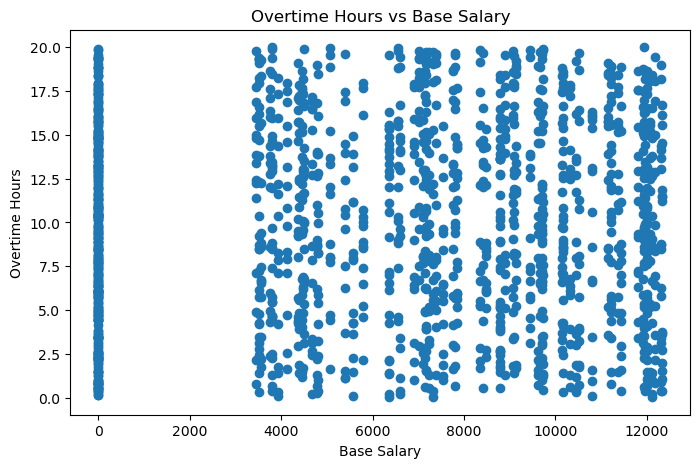

In [11]:
plt.figure(figsize=(8,5))
plt.scatter(df['base_salary'].fillna(0), df['overtime_hours'])
plt.xlabel("Base Salary")
plt.ylabel("Overtime Hours")
plt.title("Overtime Hours vs Base Salary")
plt.show()


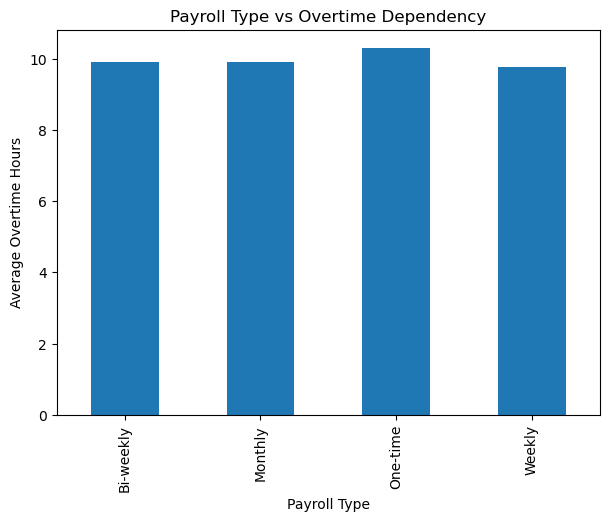

In [12]:
payroll_ot = df.groupby('payroll_type')['overtime_hours'].mean()

plt.figure(figsize=(7,5))
payroll_ot.plot(kind='bar')
plt.xlabel("Payroll Type")
plt.ylabel("Average Overtime Hours")
plt.title("Payroll Type vs Overtime Dependency")
plt.show()

In [13]:
features = [
    'overtime_hours',
    'overtime_ratio',
    'overtime_pay_ratio',
    'gross_earnings'
]

X = df[features]


In [14]:
model = IsolationForest(
    n_estimators=200,
    contamination=0.05,  # assume 5% abnormal overtime
    random_state=42
)

df['ml_anomaly'] = model.fit_predict(X)

# Convert to binary flag
df['ml_overtime_abuse'] = df['ml_anomaly'].apply(
    lambda x: 1 if x == -1 else 0
)

df['ml_overtime_abuse'].value_counts()


C:\Users\chsri\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


0    1425
1      75
Name: ml_overtime_abuse, dtype: int64

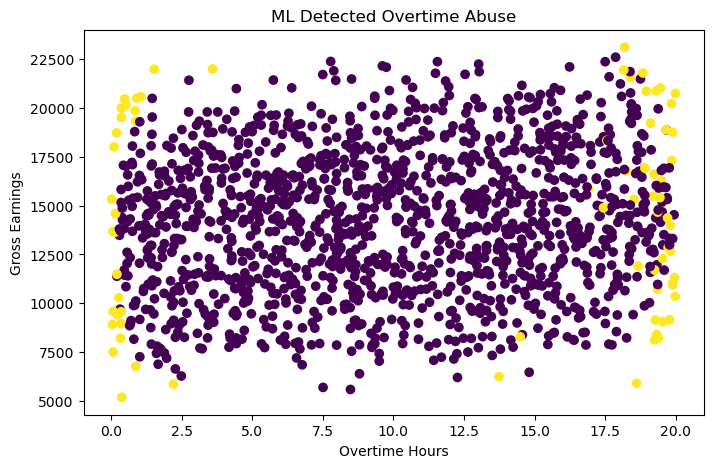

In [15]:
plt.figure(figsize=(8,5))
plt.scatter(
    df['overtime_hours'],
    df['gross_earnings'],
    c=df['ml_overtime_abuse']
)
plt.xlabel("Overtime Hours")
plt.ylabel("Gross Earnings")
plt.title("ML Detected Overtime Abuse")
plt.show()


In [16]:
repeat_ot = (
    df[df['overtime_hours'] > 15]
    .groupby('employee_id')
    .size()
    .reset_index(name='high_overtime_count')
)

df = df.merge(repeat_ot, on='employee_id', how='left')
df['high_overtime_count'] = df['high_overtime_count'].fillna(0)

df['repeat_abuser'] = df['high_overtime_count'] >= 3


In [17]:
df['final_overtime_abuse'] = np.where(
    (df['ml_overtime_abuse'] == 1) &
    (df['repeat_abuser'] == True),
    1,
    0
)

df['final_overtime_abuse'].value_counts()


0    1452
1      48
Name: final_overtime_abuse, dtype: int64

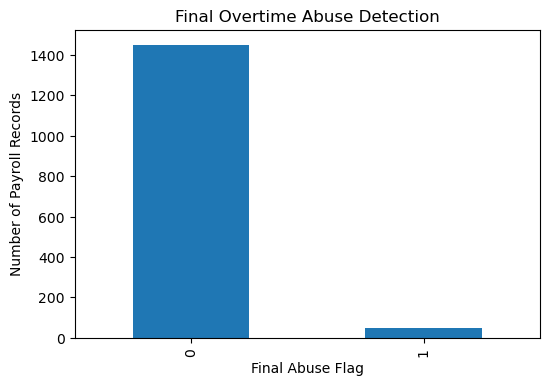

In [18]:
plt.figure(figsize=(6,4))
df['final_overtime_abuse'].value_counts().plot(kind='bar')
plt.xlabel("Final Abuse Flag")
plt.ylabel("Number of Payroll Records")
plt.title("Final Overtime Abuse Detection")
plt.show()


In [19]:
abuse_cases = df[df['final_overtime_abuse'] == 1][
    ['employee_id','overtime_hours','gross_earnings','payroll_type']
]

abuse_cases.head(10)


,employee_id,overtime_hours,gross_earnings,payroll_type
2,3,0.05,8907.75,Monthly
70,71,1.53,21996.90,Weekly
82,83,19.81,12663.95,Monthly
134,35,0.22,9409.85,Monthly
148,49,0.88,19329.41,Monthly
195,96,19.28,9133.79,Monthly
256,57,0.08,9580.64,Monthly
400,1,19.20,15483.30,Monthly
404,5,0.11,18008.00,Monthly
407,8,13.74,6228.71,Bi-weekly
